In [1]:
from obspy import read, read_inventory 
from obspy.geodetics import degrees2kilometers
from obspy.signal import rotate

from scipy.io import savemat
from os.path import join as pjoin
import numpy as np

import plotly.graph_objects as go

In [2]:
directory = '/Users/23brianc/Documents/Internship2020/Events/Canada_38/'
corrected_directory = '/Users/23brianc/Documents/Internship2020/Events/Canada_38/corrected1/*'

# Read data

In [3]:
full_stream = read(corrected_directory)
inventory = read_inventory(directory+'inventory.xml',format='STATIONXML')

In [4]:
inventory

Inventory created at 2021-07-28T00:16:55.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2008-01-02...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (21):
			BK, CC, CN, II, IM, IU, IW, LB, LI, PN, PO, TA, UO, US, UW, XC, XT
			XU, Y5, YW, ZG
		Stations (500):
			BK.HUMO (Hull Mountain, OR, USA)
			BK.MOD (Modoc Plateau, CA, USA)
			CC.PANH (Panhandle Gap)
			CC.PRLK (Prince Lake)
			CC.STD (Studebaker Ridge, Mount St. Helens)
			CC.SWFL (Southwest Flank)
			CC.VALT (Vault, Mount St. Helens)
			CC.WIFE (The Wife)
			CN.BMBC (Bull Mountain, BC, CA)
			CN.BMSB (Bamfield Marine Station, BC, CA)
			CN.CBB (Campbell River, BC, CA)
			CN.EDB (Eliza Dome, BC, CA)
			CN.EDM (Edmonton, AB, CA)
			CN.HNB (Haney, BC, CA)
			CN.LLLB (Lillooet, BC, CA)
			CN.LZB (Mount Lazard, BC, CA)
			CN.MCMB1 (Michelle Canyon Maxwell, BC, CA)
			CN.NLLB (Nanaimo Lost Lake, BC, CA)
			CN.OZB (Mt. Ozzard, BC, 

# Process Data

## Define the picking callback function


In [5]:
#------- Parameter might need to be changed for different regions or stations

snr_req = 3

H = 42.7900
depth = 38.4

vsn_min = 4.0 #vsm range
vsn_max = 4.8
    
vlg_min = 3.1 #vsc range
vlg_max = 3.6
    
vpm = 8.1 #velocity of p in mantle
vsm = 4.6 #velocity of s in mantle
vpc = 6.1 #velocity of p in crust
vsc = 3.5 #velocity of s in crust

In [6]:
import math


# def snlg(trace, points, selector):
def snlg(trace):
    '''
    A callback function that performs the following tasks for each trace:
    1. Save the entire trace
    2. Calculate and save 7 indicies for : P arrival. Noise start and end. Sn start and end. Lg start and end. 
    '''

    dt = 0.01
    #-----------------------------------
    
    dist = trace.meta['epi_dist']
    
    stlo = trace.meta['stlo']
    
    stla = trace.meta['stla']
    
    stnm = trace.meta['stnm']
    
    counter = trace.meta['number']
    
    baz = trace.meta['baz']
    
    o_in = trace.meta['o_in']
    
    
    #-----------------------------------
    depth = 38.4
    
    tp = dist/vpm + (2*H-depth)*math.sqrt(vpm*vpm-vpc*vpc)/(vpm*vpc)
    
    tsn_min = dist/vsn_max + (2*H-depth)*math.sqrt(vsn_max*vsn_max-vlg_min*vlg_min)/(vsn_max*vlg_min)
    tsn_max = dist/vsn_min + (2*H-depth)*math.sqrt(vsn_min*vsn_min-vlg_max*vlg_max)/(vsn_min*vlg_max)
    
    tlg_min = math.sqrt(dist*dist+depth*depth)/vlg_max
    tlg_max = math.sqrt(dist*dist+depth*depth)/vlg_min
    #-----------------------------------
    
    # Noise window that is 20 seconds long and start 25s befor P arrival time
    noise_start = int((tp-25)/dt)
    noise_end = int((tp-5)/dt)
    
    
    # Transform the time marks for Sn and Lg windows, as well as P to indicies
    sn_start = int((tsn_min-o_in)/dt)
    lg_start = int((tlg_min-o_in)/dt)
    sn_end = int((tsn_max-o_in)/dt)
    lg_end = int((tlg_max-o_in)/dt)
    idx_p = int((tp-o_in)/dt)
    
    # Cut the windows
    sn_time = trace.x[sn_start:sn_end]
    sn = trace.y[sn_start:sn_end]
    lg_time=trace.x[lg_start:lg_end]
    lg =trace.y[lg_start:lg_end]
    noise_time = trace.x[noise_start:noise_end]
    noise = trace.y[noise_start:noise_end]
    
    # Update figure (only for plotting purposes)
    with allfigures[counter].batch_update():
        # 1 P arrival
        allfigures[counter].add_trace(go.Scatter(x=np.array([tp,tp]),
                                                 y=np.array([np.max(trace.y),np.min(trace.y)]),
                                                 mode='lines',
                                                 name='P arrival',
                                                 line=dict(color='yellow')
                                                    ))
        # 2 Sn window
        allfigures[counter].add_trace(go.Scatter(x=sn_time,
                                                 y=sn,
                                                 mode='lines',
                                                 name='Sn',
                                                 line=dict(color='red'),
                                                 ))
        # 3 Lg window
        allfigures[counter].add_trace(go.Scatter(x=lg_time,
                                                 y=lg,
                                                 mode='lines',
                                                 name='Lg',
                                                 line=dict(color='cyan'),
                                                 ))
        # 4 Noise window
        allfigures[counter].add_trace(go.Scatter(x=noise_time,
                                                 y=noise,
                                                 mode='lines',
                                                 name='noise',
                                                 line=dict(color='green'),
                                                 ))
        # 5 4 km/s test window
        allfigures[counter].add_trace(go.Scatter(x=noise_time,
                                                 y=noise,
                                                 mode='lines',
                                                 name='noise',
                                                 line=dict(color='green'),
                                                 ))
        
    
        
    # Signal to noise ratio
    SNRsn = np.sqrt(np.mean(np.square(sn)))/np.sqrt(np.mean(np.square(noise)))
    SNRlg = np.sqrt(np.mean(np.square(lg)))/np.sqrt(np.mean(np.square(noise)))
    # Sn/Lg ratio
    snlgr = np.sqrt(np.mean(np.square(sn)))/np.sqrt(np.mean(np.square(lg)))
    if SNRsn >snr_req or SNRlg >snr_req:
        stor_trace = dict({"x":trace.x,
                      "y":trace.y,
                      "p":idx_p,
                      "sn_start":sn_start,
                      "sn_end":sn_end,
                      "lg_start":lg_start,
                      "lg_end":lg_end,
                      "noise_start":noise_start,
                      "noise_end":noise_end,
                      "epi_dist":dist,
                      "stlo":stlo,
                      "stla":stla,
                      "snlgr":snlgr,
                      "stnm":stnm,
                      "baz":baz,
                      "o_in":o_in,
                      "SNRsn":SNRsn,
                      "SNRlg":SNRlg})
        good_traces.append(stor_trace)

    


## Process data and save figure objects

Begin:
0.000466
Origin:
-0.011
BK.HUMO


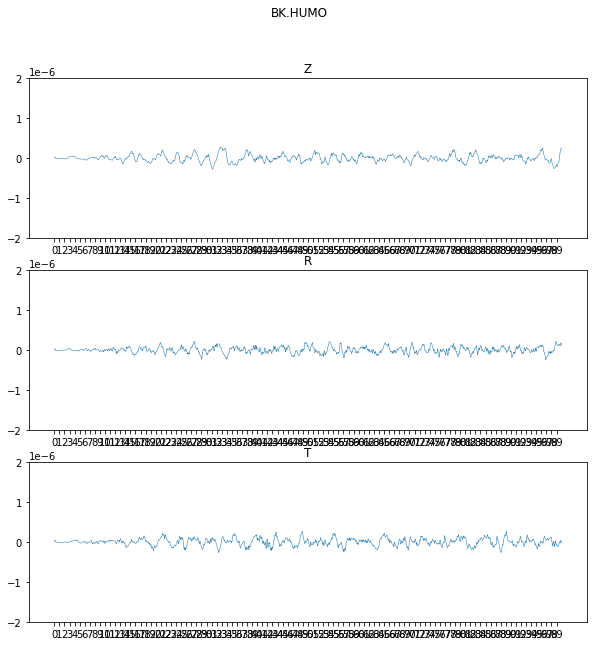

Begin:
0.0
Origin:
-0.01
CC.STD


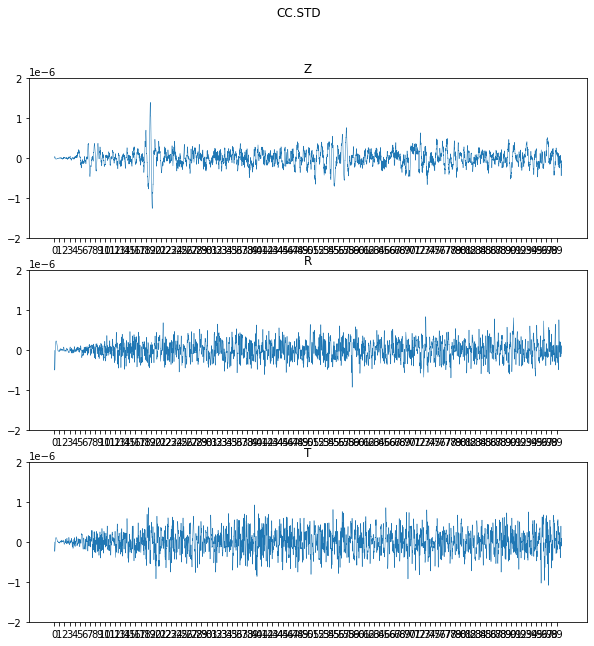

Begin:
0.0
Origin:
-0.01
CC.VALT


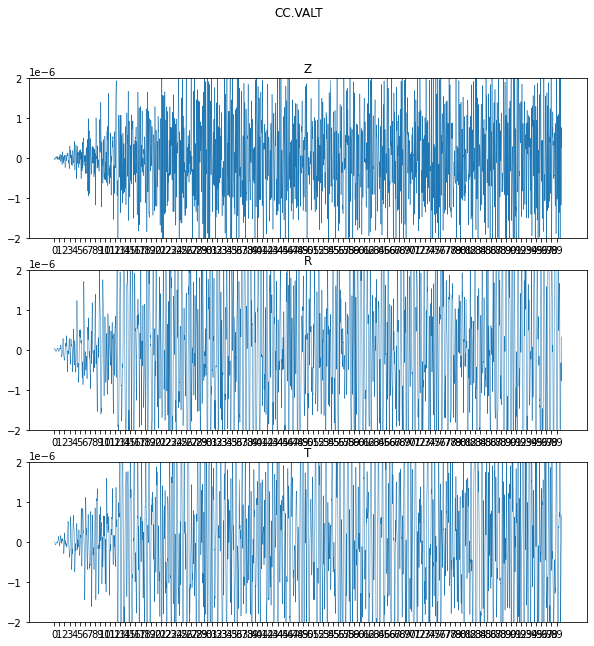

Begin:
0.0
Origin:
-0.01
CC.WIFE


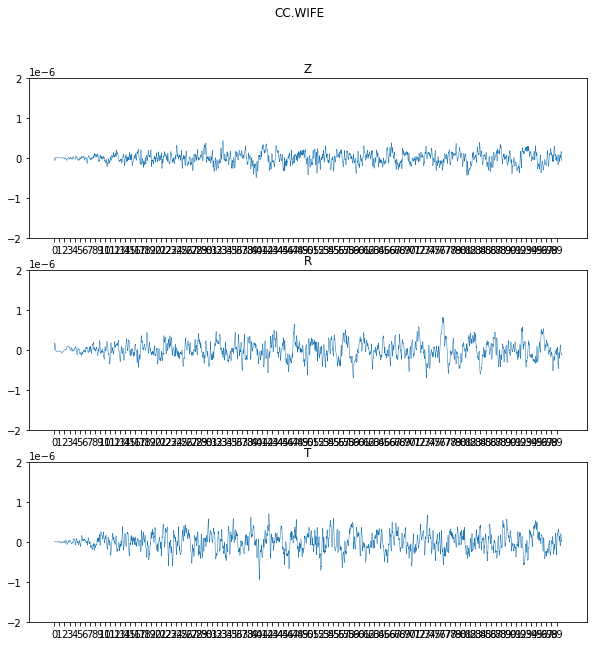

Begin:
0.0
Origin:
-0.005
CN.LLLB


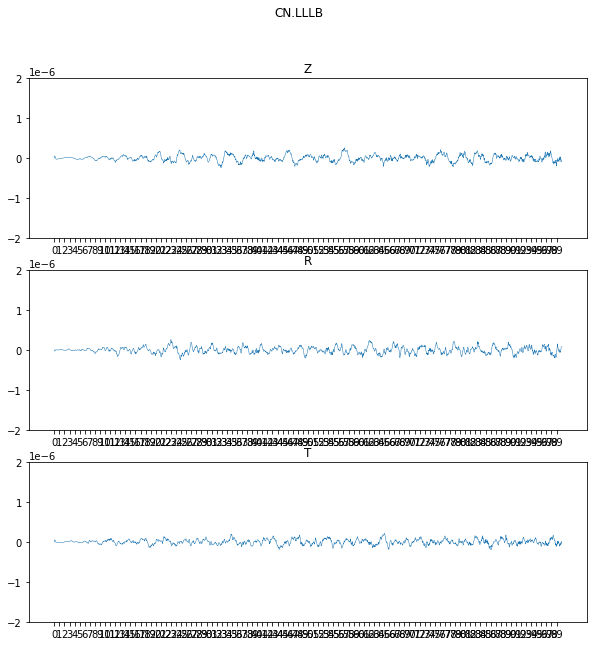

Begin:
0.0009
Origin:
-0.048
II.FFC


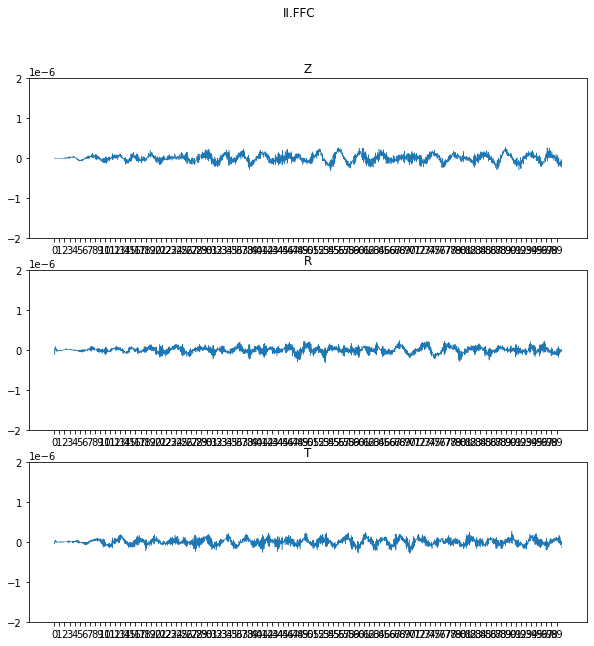

Begin:
0.0
Origin:
-0.005
IM.PD31


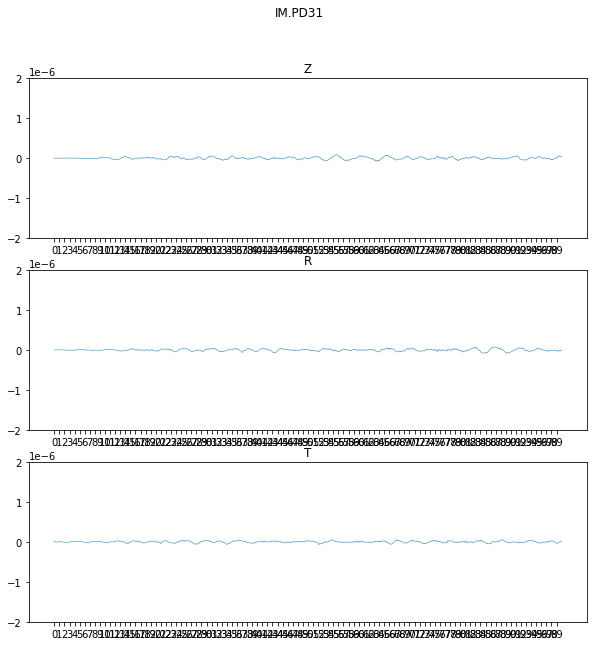

Begin:
0.000641
Origin:
-0.015
IU.COR


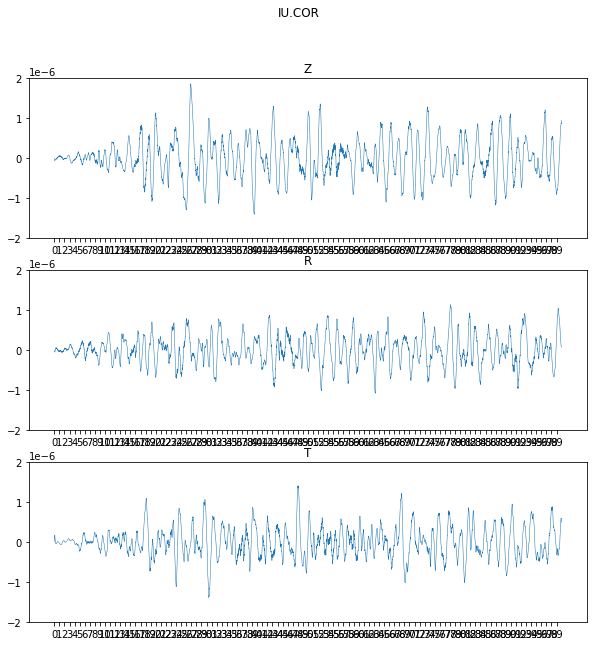

There are more than 1 location for station IU.RSSD !!
Begin:
0.0
Origin:
-0.02
IW.DCID1


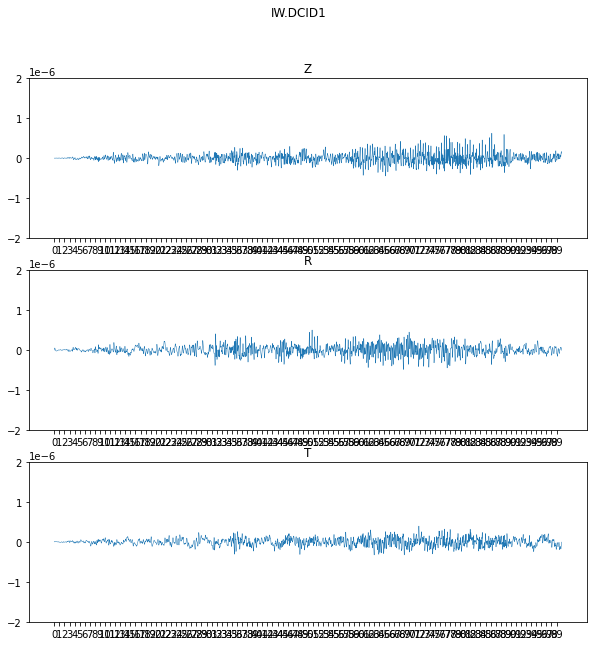

Begin:
0.0
Origin:
-0.02
IW.DLMT


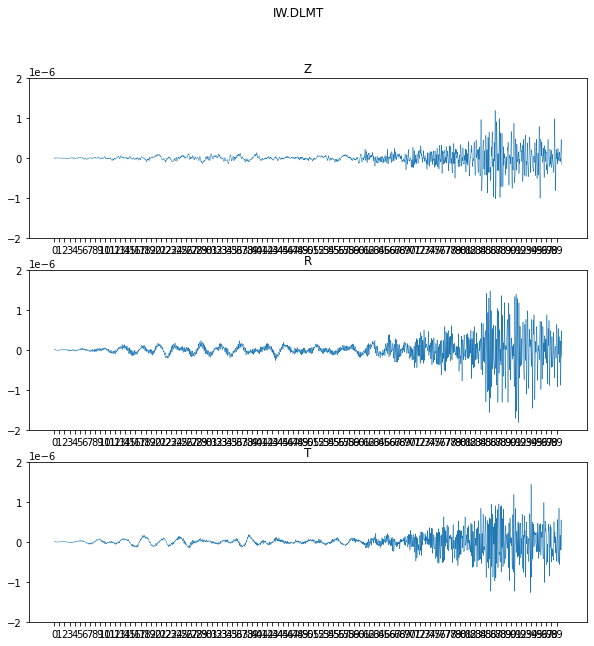

Begin:
0.0
Origin:
-0.01
IW.IMW


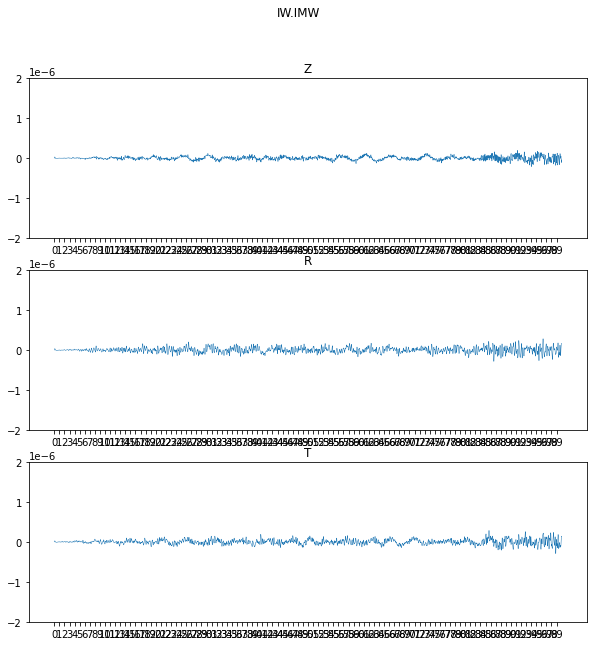

Begin:
0.0
Origin:
-0.02
IW.LOHW


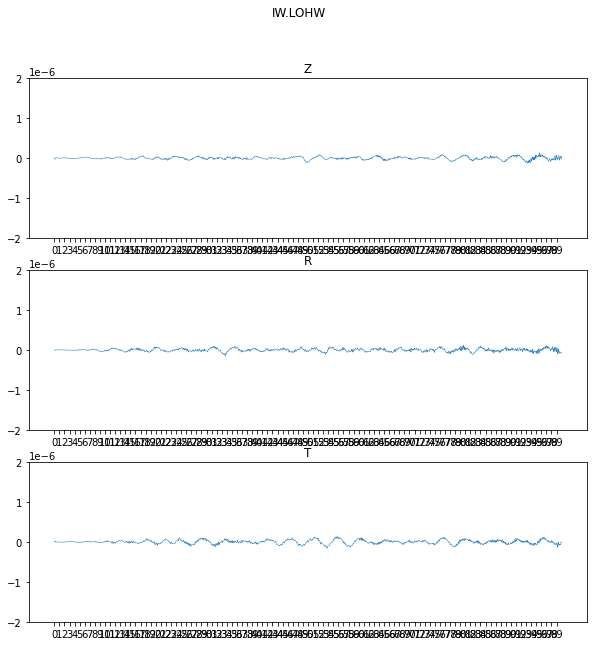

Begin:
0.0
Origin:
-0.02
IW.PHWY


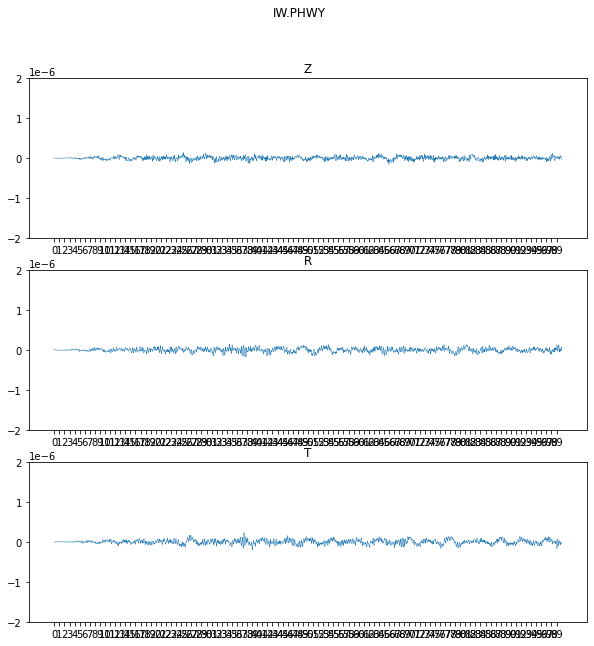

Begin:
0.0
Origin:
-0.01
IW.REDW


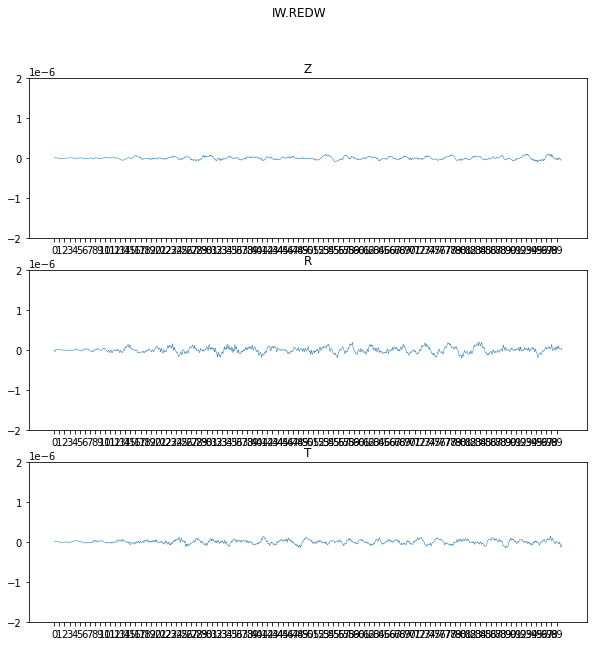

Begin:
0.0
Origin:
-0.02
IW.RRI2


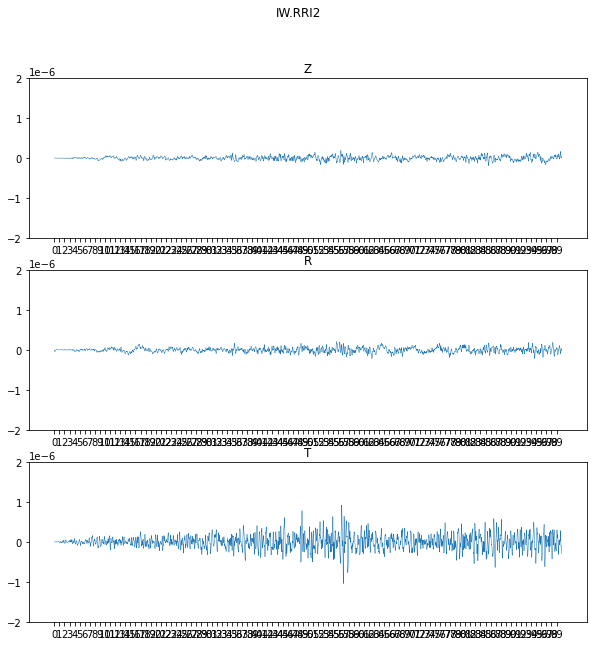

Begin:
0.0
Origin:
-0.02
IW.RWWY


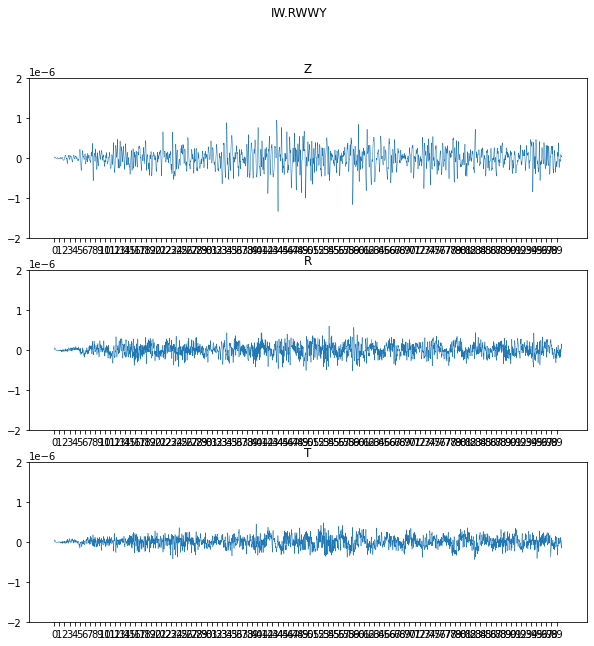

Begin:
0.0
Origin:
-0.02
IW.SNOW


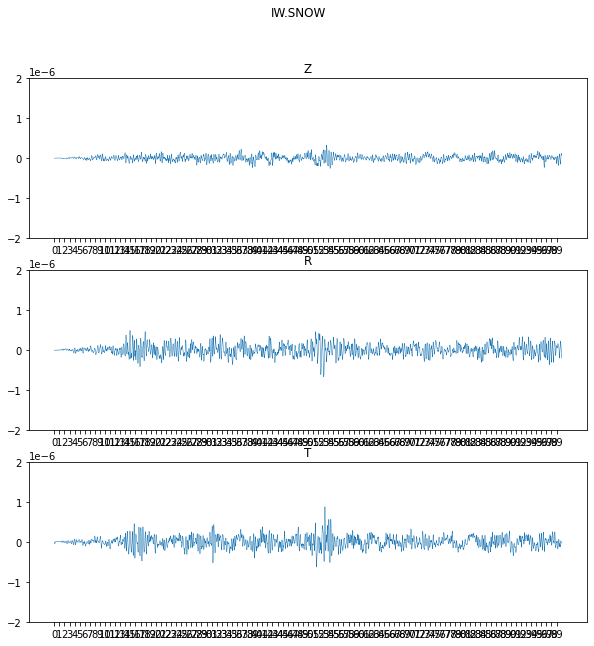

Begin:
0.0009
Origin:
-0.002
LI.LTH


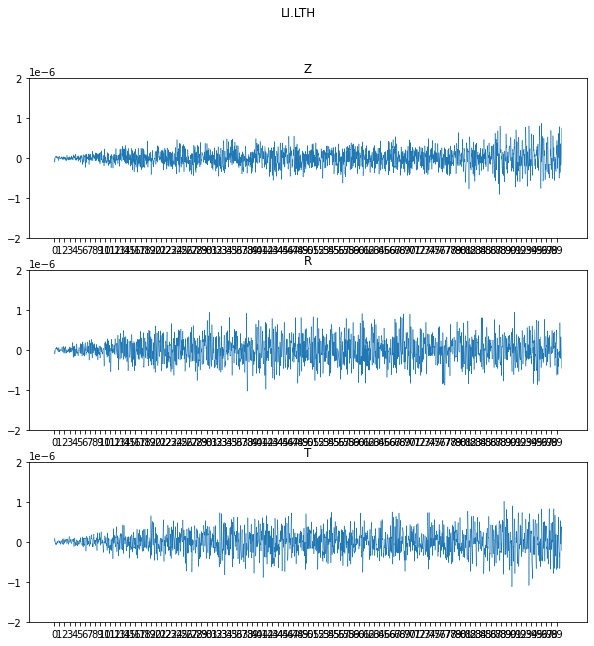

Begin:
0.0
Origin:
-0.005
TA.A04A


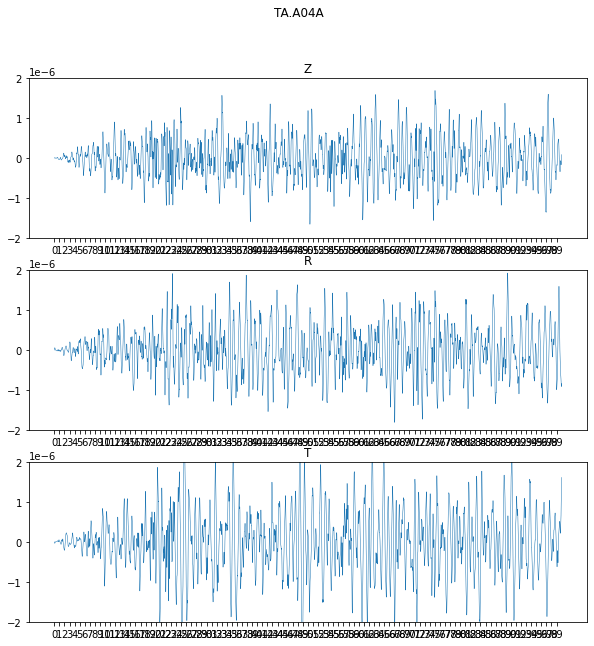

Begin:
0.0
Origin:
-0.005
TA.A05A


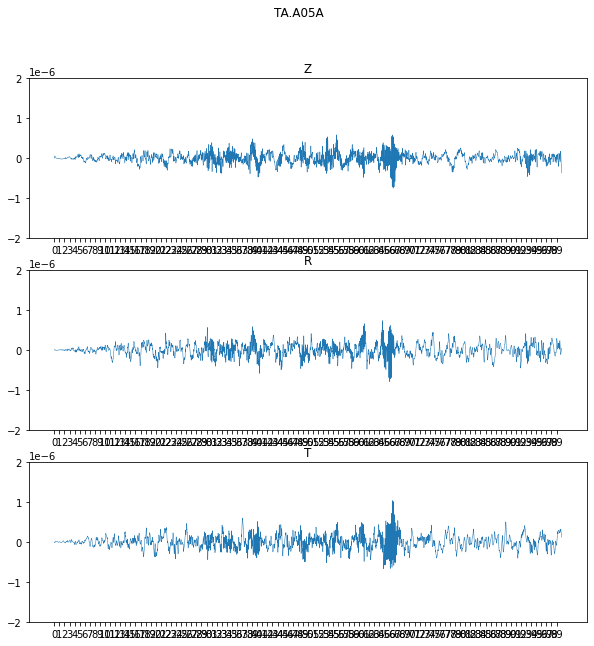

Begin:
0.0
Origin:
-0.005
TA.A06A


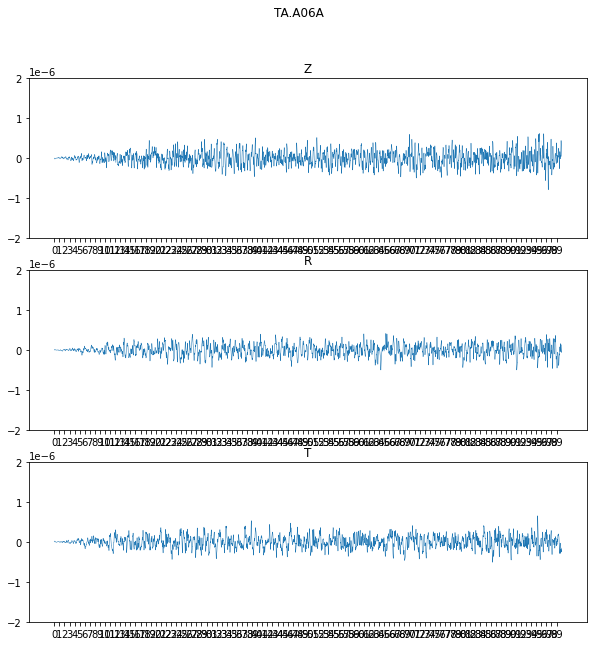

Begin:
0.0
Origin:
-0.005
TA.A07A


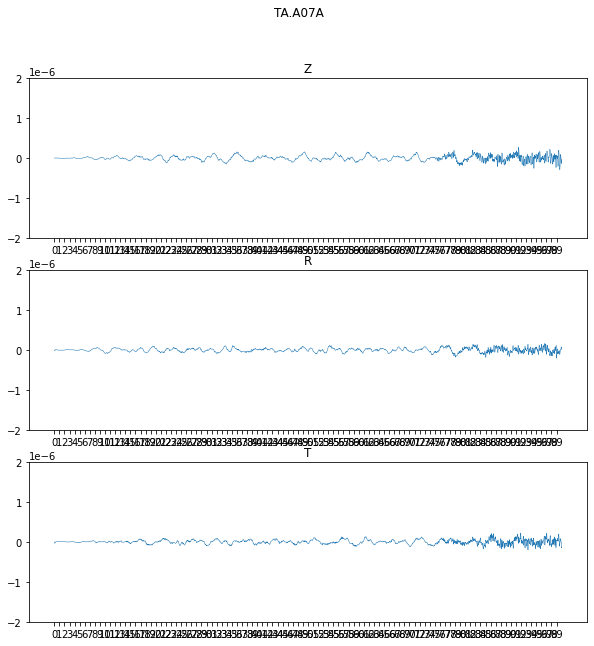

Begin:
0.0
Origin:
-0.005


AttributeError: 'numpy.ndarray' object has no attribute 'interpolate'

In [14]:

import matplotlib.pyplot as plt
import copy


counter = -1
allfigures = []
good_traces=[]

networks = []
i = 0
networks.append(str(inventory[0].code))

for net in inventory[:]:
    
    if str(net.code) != networks[i]:
        networks.append(str(net.code))
        i = i + 1
    
    for stn in net[:]:
        
        stn_stream = full_stream.select(network=net.code,station=stn.code)
        
        if len(stn_stream) > 3:
            print('There are more than 1 location for station '+net.code+'.'+stn.code+' !!')
        elif len(stn_stream) == 3:
            E = stn_stream[0]
            N = stn_stream[1]
            Z = stn_stream[2]
            
            ## Basic parameters  
            # original sample rate (s)
            dt_in= E.stats.sac['delta']
            # begin time
            b_in = E.stats.sac['b']
            print("Begin:")
            print(b_in)
            # number of points
            npts_in = E.stats.sac['npts']
            # event origin time
            o_in = E.stats.sac['o']
            print("Origin:")
            print(o_in)
            # end time
            e_in = b_in+(npts_in-1)*dt_in
            # full time series
            T = np.arange(b_in, e_in, dt_in)
            
            # station locations
            stlo = E.stats.sac['stlo']
            stla = E.stats.sac['stla']
            
            # epicentral distance (angle)
            gcarc = E.stats.sac['gcarc']
            
            # epicentral distance (km)
            dist = degrees2kilometers(E.stats.sac['gcarc'])
            
            # back-azimuth
            baz = E.stats.sac['baz']
            
            ## Rotation
            if(N.data.size == E.data.size):
                r_data, t_data = rotate.rotate_ne_rt(N.data,E.data,74)

                R = copy.deepcopy(N)
                T = copy.deepcopy(E)
                
                R.data = r_data
                T.data = t_data
            
#             if(N.data.size == E.data.size):
#                 l_data, q_data, t_data = rotate.rotate_zne_lqt(Z.data,N.data,E.data,74,35)
                
#                 L = copy.deepcopy(Z)
#                 Q = copy.deepcopy(N)
#                 T = copy.deepcopy(E)
                
                
#                 L.data = l_data
#                 Q.data = q_data
#                 T.data = t_data
            
            ## Resample at sample_rate (s)
            dt_out = 0.01
            if dt_in != dt_out:
                Z.interpolate(100,method='cubic')
                R.interpolate(100,method='cubic')
                T.interpolate(100,method='cubic')
            
            # new full time series
            t_shift = b_in-dt_out
            t_start = dt_out
            t_end = e_in-t_shift
            t = np.arange(b_in,len(T)*dt_out,dt_out)
            
            ## Bandpass filter
            Z_filt = Z.copy()
            R_filt = R.copy()
            T_filt = T.copy()
            
            freq_min = 1
            freq_max = 5
            Z_filt.filter('bandpass',freqmin=freq_min,freqmax=freq_max,corners=2)
            R_filt.filter('bandpass',freqmin=freq_min,freqmax=freq_max,corners=2)
            T_filt.filter('bandpass',freqmin=freq_min,freqmax=freq_max,corners=2)
            
            
            #print(net.code+'.'+stn.code)
            
            print(net.code+'.'+stn.code)
            
            ### Plot the three components and hodographs
            
            t_range_min = 0
            t_range_max = 100 #in seconds
            lw = 0.5
            yl_min=-0.000002
            yl_max=0.000002
            
            fig, axs = plt.subplots(3)
            fig.suptitle(net.code+'.'+stn.code)
            
            major_ticks = np.arange(t_range_min, t_range_max, 1)
#             minor_ticks = np.arange(t_range_min, t_range_max, 1)
            
            axs[0].plot(t[int(t_range_min*100):int(t_range_max*100)], 5*Z_filt.data[int(t_range_min*100):int(t_range_max*100)], linewidth=lw)
            axs[0].set_title('Z')
            axs[0].set_ylim(yl_min, yl_max) 
            axs[0].set_xticks(major_ticks)
#             axs[0].set_xticks(minor_ticks, minor=True)
            
            axs[1].plot(t[int(t_range_min*100):int(t_range_max*100)], 5*R_filt.data[int(t_range_min*100):int(t_range_max*100)], linewidth=lw)
            axs[1].set_title('R')
            axs[1].set_ylim(yl_min, yl_max)
            axs[1].set_xticks(major_ticks)
#             axs[1].set_xticks(minor_ticks, minor=True)
            
            axs[2].plot(t[int(t_range_min*100):int(t_range_max*100)], 5*T_filt.data[int(t_range_min*100):int(t_range_max*100)], linewidth=lw)
            axs[2].set_title('T')
            axs[2].set_ylim(yl_min, yl_max)
            axs[2].set_xticks(major_ticks)
#             axs[2].set_xticks(minor_ticks, minor=True)
            
    
            fig.set_size_inches(10, 10)
            
            
#             plt.savefig(stn.code+ '.png', dpi=300)
            plt.show()
            
            ### Plot data
            counter +=1
            

            fig = go.FigureWidget()
            fig.add_trace(go.Scatter(x=t,y=T_filt.data,mode='lines',line=dict(color='black'),name='T component',
                                       meta=dict(epi_dist=dist,baz=baz,o_in=o_in,number=counter,stlo=stlo,stla=stla,
                                                 stnm=net.code+'.'+stn.code)))

            fig.update_xaxes(range=[0,500])
            fig.update_layout(title=net.code+'.'+stn.code,
                              xaxis_title='Time (s)',yaxis_title='Amplitude')
            
            
            allfigures.append(fig)
            
            
            

            

## Pick first arrival and get windows

In [8]:

for k in range(0,len(allfigures)):
    snlg(allfigures[k].data[0])
    display(allfigures[k])

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 43.093582,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 60.904755,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 60.669334,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 46.652649,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 99.226418,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 235.24184,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 342.00021,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 53.054153,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 349.41931,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.96152,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.25647,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 345.75284,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 329.54669,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.80661,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 350.67645,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 334.56516,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.01587,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 55.144859,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 81.295967,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 83.780602,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 84.819656,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 84.384117,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 83.06646,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 83.119324,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 82.607803,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 76.161423,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 77.064682,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 79.089622,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 77.536613,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 75.393829,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 74.216957,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 75.867081,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 73.138794,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 71.605751,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 72.717216,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.980614,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.74662,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.693054,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.456024,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.27504,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.717545,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.727013,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 63.728775,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 59.137936,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 56.798733,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 51.585793,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.18425,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 317.25705,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.296288,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 64.346176,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 60.46204,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 57.468555,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 54.08223,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 50.344727,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 44.334808,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.746532,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.550552,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 8.8450003,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.79321,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 344.9494,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 335.78433,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 325.48444,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 59.202602,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 56.674698,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 53.999531,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 52.248753,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 47.010014,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.148048,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.414173,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.436131,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.237829,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.86101,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 6.0236855,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 356.55573,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.54538,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 337.51028,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 329.38525,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 57.075817,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 54.718693,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 51.99411,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 49.919834,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 46.781681,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 44.08773,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 38.351948,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.722744,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 29.902071,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 12.506701,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 6.0135417,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.07971,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 350.79642,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 341.20853,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 332.09427,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 54.93816,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 53.51305,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 50.978767,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 48.136768,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.80019,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.146294,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 38.004597,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.961792,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.437231,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.393951,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.740557,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 11.313083,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 4.4720135,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 358.66745,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.44208,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 343.41257,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 51.232864,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 49.884583,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.5956,
              …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 41.021584,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 39.116764,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.379799,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.821083,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 26.41391,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 20.852404,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.43437,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 9.0491114,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 4.4893188,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.69537,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 350.90891,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 344.79831,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 340.76956,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.549671,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.977398,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 31.48333,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.211502,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 23.645857,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 18.510399,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 13.908885,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 8.6266508,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 4.4501557,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.60049,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 352.56555,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 346.96759,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 343.32913,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.795322,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 31.950563,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 29.092588,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.735001,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 22.042534,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.861891,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 11.633944,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 7.17068,
              …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 2.0413082,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 358.41095,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 352.93246,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 349.28647,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 344.79721,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 338.28922,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 336.41452,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 29.91884,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 26.686808,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 23.398706,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 18.299622,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.109507,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 11.431014,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 5.9019871,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 2.2286565,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.81351,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 352.91928,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 346.17111,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 342.6142,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 338.27731,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 334.38403,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 330.60168,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 27.373032,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.652233,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 20.959515,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.382542,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 13.930544,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 9.939064,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 6.4025307,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 2.5951614,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 358.25989,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 354.45264,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 349.81473,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 347.14548,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 342.98602,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 338.94601,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 335.38535,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 333.10736,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.039612,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 22.077858,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 19.962376,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.734342,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 12.73671,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 9.8258648,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 6.1970444,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 1.6817263,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 358.70203,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 353.87784,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 351.17365,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 346.14108,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 344.22656,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 340.71808,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 338.09393,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 334.24121,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 21.079649,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.385748,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.001777,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 11.514299,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 8.017025,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 4.8065662,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 358.57721,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 354.59735,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 351.49625,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 348.50278,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 345.00375,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 341.99222,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 339.09793,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 1.0066494,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 357.94086,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 355.53214,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 350.1225,
             …

/Users/23brianc/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/Users/23brianc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.906719,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 49.685894,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.578861,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.086452,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 348.19104,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 342.00253,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 0.014914613,
          …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 10.553792,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 54.941803,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 10.390095,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 71.491821,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 331.18808,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.654892,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 71.794952,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 57.393372,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 53.409176,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 63.910667,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.917519,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 63.915775,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 75.688553,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 76.443893,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 76.032692,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 50.535122,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 54.505833,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.461937,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.25572,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 21.517366,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 21.269487,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 18.53985,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 19.253494,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.050344,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 22.040232,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 20.947308,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 18.063562,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.424366,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 19.839237,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 16.476414,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 15.586452,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 17.073599,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.172272,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.489624,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 46.846924,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 46.025875,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.832264,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 38.052479,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 46.841007,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.815533,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.149635,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 43.768803,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.944962,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.251633,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 43.196388,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.205738,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 44.484669,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 43.56847,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.840427,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 35.678375,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 41.674721,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.070107,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 35.135529,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.160091,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 41.491322,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.90591,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 35.790142,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 39.654366,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.205677,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.054905,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 38.829098,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.501846,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.020187,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.534771,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.490948,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.812595,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 38.533566,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.983356,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.276733,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.09816,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 39.573189,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.453945,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 35.186638,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.38052,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.561676,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.196249,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.4111,
              …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.327641,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.783245,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 36.106277,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.957016,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.55806,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 31.580811,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.730095,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.956474,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 26.673143,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.245207,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.29789,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.993807,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.979206,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.793545,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.698088,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.130135,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 27.246784,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.758846,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.575523,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.473431,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.969852,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 23.31196,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.462812,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 32.20784,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 29.941404,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.531752,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 27.840023,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 23.381273,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 22.577972,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 26.332232,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.697563,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.078209,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 29.967257,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 24.622366,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 31.217886,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 41.608521,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.644669,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 75.011559,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 72.891136,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.571716,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 64.571846,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 61.799473,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 63.284206,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.446854,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.682594,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.716187,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.903931,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 70.059341,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.831924,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.824219,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.022522,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.70993,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.346977,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.364395,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.009979,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.258194,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.791107,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.127502,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.608994,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 71.278999,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.145714,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 69.34166,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.797516,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.299278,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 68.039398,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.149124,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.009949,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.80854,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.463898,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.23233,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 65.315536,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 64.393829,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 73.846901,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 72.367775,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 70.434921,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 67.462708,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 66.069199,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 64.509331,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 62.581463,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 209.75995,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 186.65742,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 172.00893,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 145.7187,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 50.158546,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 73.503731,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 61.579613,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 57.852905,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 56.978989,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 48.736595,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 47.002495,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 25.016869,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 26.360529,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 28.385569,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 30.387133,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 31.952641,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 37.036922,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.075581,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.397484,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 40.929089,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 41.646755,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 42.589924,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 44.60796,
             …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 45.877964,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 47.742657,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 49.235279,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 33.358471,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.145458,
            …

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'meta': {'baz': 34.583668,
            …

In [39]:
# import copy

# good_traces_shallow = copy.deepcopy(good_traces)

# %store good_traces_shallow

Stored 'good_traces_shallow' (list)


In [9]:
len(good_traces)

119

# Craton Path Record Section

In [18]:
craton_paths = []

min_baz = 100
max_baz = 270

for i in good_traces:
    if i.get("baz") > min_baz and i.get("baz") < max_baz:
#     if i.get("baz") > 0 and i.get("baz") < 150:

        craton_paths.append(i)
    
    
    
len_craton_paths = len(craton_paths)
len(craton_paths)

3

In [34]:
for i in craton_paths:
#         print(i.get("stnm"))
        if i.get("stnm") == "US.HLID":
            local_max = max(i.get("y"))
            
local_max

4.319187140981437e-05

In [21]:
# import plotly.offline as pyo
# # Set notebook mode to work in offline
# pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default = "browser"

ult_max = 0

time_before_P = 30
time_after_P = 430
full_time = np.arange(0,time_before_P+time_after_P,dt_out)

all_horiz = np.arange(1,2*len_craton_paths,2)

record_section = go.Figure()

for k in range (0, len_craton_paths):
            
        
    horiz = all_horiz[k]

    stnm = str(craton_paths[k].get("stnm"))
    
    epi_dist = craton_paths[k].get("epi_dist")
    
    # Index for P arrival
    idx_P = craton_paths[k].get("p")

    full_time = craton_paths[k].get("x")
    
    # cut out corresponding data and normalize to self
    m = max(craton_paths[k].get("y"))
    
#     for i in craton_paths:
#         print(i.get("stnm"))
#         if i.get("stnm") = "US.DUG":
#             local_max = max(i.get("y"))
    
#     if m > ult_max:
#         ult_max = m
    
    seis = craton_paths[k].get("y")/m*20 + epi_dist
#     seis = craton_paths[k].get("y")/4.319187140981437e-05*50*epi_dist/300 + epi_dist


    # Sn, Lg and noise windows indicies
    idxsn_start =  craton_paths[k].get("sn_start")
    idxsn_end =  craton_paths[k].get("sn_end")
    idxlg_start =  craton_paths[k].get("lg_start")
    idxlg_end =  craton_paths[k].get("lg_end")
    idxnoise_start =  craton_paths[k].get("noise_start")
    idxnoise_end =  craton_paths[k].get("noise_end")
    
#     print(stnm)
#     print(epi_dist)
#     print(len(seis))
#     print(idxnoise_start)
#     print(idxnoise_end)
    

    
    # Cut out these windows from seis_cut
    
    time4 = epi_dist/4
#     time4 = 0

    
    sn_time = full_time[idxsn_start:idxsn_end] - time4
    lg_time = full_time[idxlg_start:idxlg_end] - time4
    noise_time = full_time[idxnoise_start:idxnoise_end] - time4
    reduced_time = full_time - time4


    sn = seis[idxsn_start:idxsn_end]
    lg = seis[idxlg_start:idxlg_end]
    noise = seis[idxnoise_start:idxnoise_end]
    
#     print(seis)

    with record_section.batch_update():
        record_section.add_trace(go.Scatter(x=seis,
                                            y=reduced_time,
                                            mode='lines',
                                            line=dict(color='black'),
                                            text = stnm
                                                    ))
#         record_section.add_trace(go.Scatter(x=sn,
#                                             y=sn_time,
#                                             mode='lines',
#                                             line=dict(color='red'),
#                                             text = stnm
#                                                     ))
#         record_section.add_trace(go.Scatter(x=lg,
#                                             y=lg_time,
#                                             mode='lines',
#                                             line=dict(color='cyan'),
#                                             text = stnm
#                                                     ))
#         record_section.add_trace(go.Scatter(x=noise,
#                                             y=noise_time,
#                                             mode='lines',
#                                             line=dict(color='green'),
#                                             text = stnm
#                                                     ))
        
        

#------------ Outside of the loop ------------------

trace1 = good_traces[0]
trace2 = good_traces[1]

full_time_1 = good_traces[0].get("x")
full_time_2 = good_traces[1].get("x")

epi1 = trace1.get("epi_dist")
epi2 = trace2.get("epi_dist")

time4_1 = epi1/4
time4_2 = epi2/4


# #------------ P-arrival line ------------------

p1 = full_time_1[trace1.get("p")]-time4_1
p2 = full_time_2[trace2.get("p")]-time4_2

p_slope = (p2-p1)/(epi2 - epi1)

p_intercept = p1-p_slope*epi1

# #------------ Sn Window lines ------------------

# sn_min_1 = full_time_1[trace1.get("sn_start")]-time4_1
# sn_min_2 = full_time_2[trace2.get("sn_start")]-time4_2

# sn_min_slope = (sn_min_2-sn_min_1)/(epi2 - epi1)

# sn_min_intercept = sn_min_1-sn_min_slope*epi1


# #------------------

# sn_max_1 = full_time_1[trace1.get("sn_end")]-time4_1
# sn_max_2 = full_time_2[trace2.get("sn_end")]-time4_2

# # print(trace1.get("stnm"))
# # print(epi1)
# # print(sn_min_1)
# # print(sn_max_1)

# # print(trace2.get("stnm"))
# # print(epi2)
# # print(sn_min_2)
# # print(sn_max_2)

# sn_max_slope = (sn_max_2-sn_max_1)/(epi2 - epi1)

# sn_max_intercept = sn_max_1-sn_max_slope*epi1


# #------------ Lg Window lines ------------------

# lg_min_1 = full_time_1[trace1.get("lg_start")]-time4_1
# lg_min_2 = full_time_2[trace2.get("lg_start")]-time4_2

# lg_min_slope = (lg_min_2-lg_min_1)/(epi2 - epi1)

# lg_min_intercept = lg_min_1-lg_min_slope*epi1

# #------------------

# lg_max_1 = full_time_1[trace1.get("lg_end")]-time4_1
# lg_max_2 = full_time_2[trace2.get("lg_end")]-time4_2

# lg_max_slope = (lg_max_2-lg_max_1)/(epi2 - epi1)

# lg_max_intercept = lg_max_1-lg_max_slope*epi1

#------------ Plotting ------------------

# depth = 38.4

dist_arr = list(range(0,1100))

tlg_min_arr = []
tlg_max_arr = []

for i in dist_arr:
    tlg_min_arr.append(math.sqrt(i*i+depth*depth)/vlg_max - i/4)
    
for i in dist_arr:
    tlg_max_arr.append(math.sqrt(i*i+depth*depth)/vlg_min - i/4)
    
tsn_min_arr = []
tsn_max_arr = []
    
tp_arr = []

for i in dist_arr:
    tp_arr.append(dist/vpm + (2*H-depth)*math.sqrt(vpm*vpm-vpc*vpc)/(vpm*vpc) - i/4)
    
    
for i in dist_arr:
    tsn_min_arr.append(i/vsn_max + (2*H-depth)*math.sqrt(vsn_max*vsn_max-vlg_min*vlg_min)/(vsn_max*vlg_min) - i/4)
    
for i in dist_arr:
    tsn_max_arr.append(i/vsn_min + (2*H-depth)*math.sqrt(vsn_min*vsn_min-vlg_max*vlg_max)/(vsn_min*vlg_max) - i/4)

record_section.add_trace(go.Scatter(x=dist_arr,
                                            y=tlg_min_arr,
                                            mode='lines',
                                            line=dict(color='magenta',width=4)
                                                    ))

record_section.add_trace(go.Scatter(x=dist_arr,
                                            y=tlg_max_arr,
                                            mode='lines',
                                            line=dict(color='magenta',width=4,dash='dash')
                                                    ))

record_section.add_trace(go.Scatter(x=dist_arr,
                                            y=tsn_min_arr,
                                            mode='lines',
                                            line=dict(color='lime',width=4)
                                                    ))

record_section.add_trace(go.Scatter(x=dist_arr,
                                            y=tsn_max_arr,
                                            mode='lines',
                                            line=dict(color='lime',width=4,dash='dash')
                                                    ))

# record_section.add_trace(go.Scatter(x=dist_arr,
#                                             y=tp_arr,
#                                             mode='lines',
#                                             line=dict(color='blue',width=4)
#                                                     ))

record_section.add_trace(go.Scatter(x=np.array([0,1100]),
                                            y=np.array([p_intercept,p_intercept+p_slope*1100]),
                                            mode='lines',
                                            line=dict(color='blue',width=4)
                                                    ))

# record_section.add_trace(go.Scatter(x=np.array([0,1100]),
#                                             y=np.array([sn_min_intercept,sn_min_intercept+sn_min_slope*1100]),
#                                             mode='lines',
#                                             line=dict(color='lime',width=4,)
#                                                     ))

# record_section.add_trace(go.Scatter(x=np.array([0,1100]),
#                                             y=np.array([sn_max_intercept,sn_max_intercept+sn_max_slope*1100]),
#                                             mode='lines',
#                                             line=dict(color='lime',width=4, dash='dash')
#                                                     ))

# record_section.add_trace(go.Scatter(x=np.array([0,1100]),
#                                             y=np.array([lg_min_intercept,lg_min_intercept+lg_min_slope*1100]),
#                                             mode='lines',
#                                             line=dict(color='magenta',width=4,)
#                                                     ))

# record_section.add_trace(go.Scatter(x=np.array([0,1100]),
#                                             y=np.array([lg_max_intercept,lg_max_intercept+lg_max_slope*1100]),
#                                             mode='lines',
#                                             line=dict(color='magenta',width=4, dash='dash')
#                                                     ))

record_section.update_yaxes(range=[-50,50])

record_section.update_xaxes(range=[600,700])

record_section.update_layout(showlegend=False,
                            title=go.layout.Title(text="Sg:" + str(vsc) + " Pg:" + str(vpc) + "    Moho:" + str(H) +
                                                  "    Sn:" + str(vsm) + " Pn:" + str(vpm) + "    Lg:" + str(vlg_min) + "-"
                                                 + str(vlg_max) + "    Sn:" + str(vsn_min) + "-" + str(vsn_max)
                                                 + "    Depth:" + str(depth) + "    baz:" + str(min_baz) + "-" +
                                                  str(max_baz) + "    SNR min req.:" + str(snr_req)),
                            xaxis_title='Epi. Dist (km)',
                            yaxis_title='Reduced time (s), Vᵣ=4 km/s')
    
record_section.show()


In [29]:
ult_max

0.0042012226134586807

In [ ]:
    tp = dist/vpm + (2*H-depth)*math.sqrt(vpm*vpm-vpc*vpc)/(vpm*vpc)
    
    tsn_min = dist/vsn_max + (2*H-depth)*math.sqrt(vsn_max*vsn_max-vlg_min*vlg_min)/(vsn_max*vlg_min)
    tsn_max = dist/vsn_min + (2*H-depth)*math.sqrt(vsn_min*vsn_min-vlg_max*vlg_max)/(vsn_min*vlg_max)
    
    tlg_min = math.sqrt(dist*dist+depth*depth)/vlg_max
    tlg_max = math.sqrt(dist*dist+depth*depth)/vlg_min

0
1
4
9
16
25
36
49
64
81
100
121
144
169
196
225
256
289
324
361
400
441
484
529
576
625
676
729
784
841
900
961
1024
1089
1156
1225
1296
1369
1444
1521
1600
1681
1764
1849
1936
2025
2116
2209
2304
2401
2500
2601
2704
2809
2916
3025
3136
3249
3364
3481
3600
3721
3844
3969
4096
4225
4356
4489
4624
4761
4900
5041
5184
5329
5476
5625
5776
5929
6084
6241
6400
6561
6724
6889
7056
7225
7396
7569
7744
7921
8100
8281
8464
8649
8836
9025
9216
9409
9604
9801
10000
10201
10404
10609
10816
11025
11236
11449
11664
11881
12100
12321
12544
12769
12996
13225
13456
13689
13924
14161
14400
14641
14884
15129
15376
15625
15876
16129
16384
16641
16900
17161
17424
17689
17956
18225
18496
18769
19044
19321
19600
19881
20164
20449
20736
21025
21316
21609
21904
22201
22500
22801
23104
23409
23716
24025
24336
24649
24964
25281
25600
25921
26244
26569
26896
27225
27556
27889
28224
28561
28900
29241
29584
29929
30276
30625
30976
31329
31684
32041
32400
32761
33124
33489
33856
34225
34596
34969
35344
35721
36100


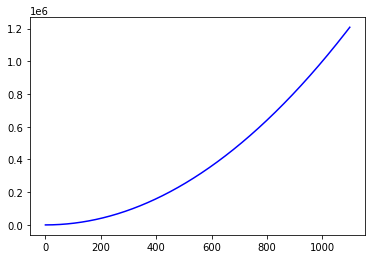

In [153]:
import matplotlib.pyplot as plt

depth = 12.3


dist_arr = list(range(0, 1100))
tlg_min_arr = []
tlg_max_arr = []

for i in dist_arr:
    tlg_min_arr.append(i*i)
    print(i*i)
    
for i in dist_arr:
    tlg_max_arr.append(math.sqrt(i*i+depth*depth)/vlg_min)
    
tsn_min_arr = []
tsn_max_arr = []
    
    
for i in dist_arr:
    tsn_min_arr.append(i/vsn_max + (2*H-depth)*math.sqrt(vsn_max*vsn_max-vlg_min*vlg_min)/(vsn_max*vlg_min))
    
for i in dist_arr:
    tsn_max_arr.append(i/vsn_min + (2*H-depth)*math.sqrt(vsn_min*vsn_min-vlg_max*vlg_max)/(vsn_min*vlg_max))
    
plt.plot(dist_arr, tlg_min_arr, 'b')
# plt.plot(dist_arr, tlg_max_arr, 'b')

# plt.plot(dist_arr, tsn_min_arr, 'r')
# plt.plot(dist_arr, tsn_max_arr, 'r')

In [17]:
all_stlo = np.array([good_traces[k].get('stlo') for k in range(0,len(good_traces))])
all_stla = np.array([good_traces[k].get('stla') for k in range(0,len(good_traces))])
all_ratio = np.array([math.log(good_traces[k].get('snlgr'), 10) for k in range(0,len(good_traces))])
all_info = np.column_stack((all_stlo,all_stla,all_ratio))
stnfile_name =  pjoin(directory,'stn.txt')
np.savetxt(stnfile_name,all_info,fmt='%1.3f',newline="\n")

# Ratio of Ratios

In [11]:
import copy
%store -r station_names_shallow
%store -r ratios_shallow

copy_good_traces = copy.deepcopy(good_traces)

common_stations = []
ratios = []

for i in copy_good_traces:
    for j in range (len(station_names_shallow)):
        if i["stnm"] == station_names_shallow[j]:
            common_stations.append(copy.deepcopy(i))
            ratios.append(ratios_shallow[j])
            
print(len(common_stations))

            
for i in range (len(common_stations)):

    common_stations[i]["snlgr"] = math.log(common_stations[i]["snlgr"]/ratios[i], 10)
    

all_stlo = np.array([common_stations[k].get('stlo') for k in range(0,len(common_stations))])
all_stla = np.array([common_stations[k].get('stla') for k in range(0,len(common_stations))])
all_ratio = np.array([common_stations[k].get('snlgr') for k in range(0,len(common_stations))])
all_info = np.column_stack((all_stlo,all_stla,all_ratio))
stnfile_name =  pjoin(directory,'ratio.txt')
np.savetxt(stnfile_name,all_info,fmt='%1.3f',newline="\n")

9
